### Initial setup

In [1]:
SEQUENCE_NAME = "sav_000001" 
TEXT_PROMPT = "boy. child playing. kid."
path = f"./sequences/{SEQUENCE_NAME}"
CALCULATE_METRICS = True

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import sys
import os
import shutil
from utils.sav_utils import SAVDataset
import pycocotools.mask as mask_util

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
MOMENTUM = 0.95

def predict_next_point(center_history):
    # Get weighted average acceleration
    velocities = np.diff(center_history, axis=0)
    accelerations = np.diff(velocities, axis=0)
    weights = np.flip(np.array([MOMENTUM ** i for i in range(accelerations.shape[0])]))
    weights = np.vstack([weights, weights]).T
    next_acceleration = np.average(accelerations, axis=0, weights=weights)
    next_velocity = velocities[-1] + next_acceleration
    # next_position = np.average(center_history, axis=0, weights=weights)
    # return np.array([next_position])
    return np.array([center_history[-1] + next_velocity])

center_history = np.array([i**1.1 for i in range(5)])
center_history = np.vstack([center_history, center_history]).T
print(center_history)
predict_next_point(center_history)

[[0.         0.        ]
 [1.         1.        ]
 [2.14354693 2.14354693]
 [3.34836952 3.34836952]
 [4.59479342 4.59479342]]


array([[5.92162548, 5.92162548]])

### Load Models

In [5]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model("./models/GroundingDINO_SwinT_OGC.py", "./models/groundingdino_swint_ogc.pth")
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

final text_encoder_type: bert-base-uncased


### Load Input

In [6]:
if os.path.exists(f"{path}/input_seq/"): 
    shutil.rmtree(f"{path}/input_seq/")
if os.path.exists(f"{path}/output_seq/"): 
    shutil.rmtree(f"{path}/output_seq/")

os.makedirs(f"{path}/input_seq/", exist_ok=True)
os.makedirs(f"{path}/output_seq/", exist_ok=True)

input_file = f"{path}/{SEQUENCE_NAME}.mp4"
output_file = f"{path}/input_seq/{SEQUENCE_NAME}_IN%04d.jpg"
os.system(f"ffmpeg -i {input_file} {output_file}")

sequence_start = 1
sequence_end = len(os.listdir(f"{path}/input_seq/"))

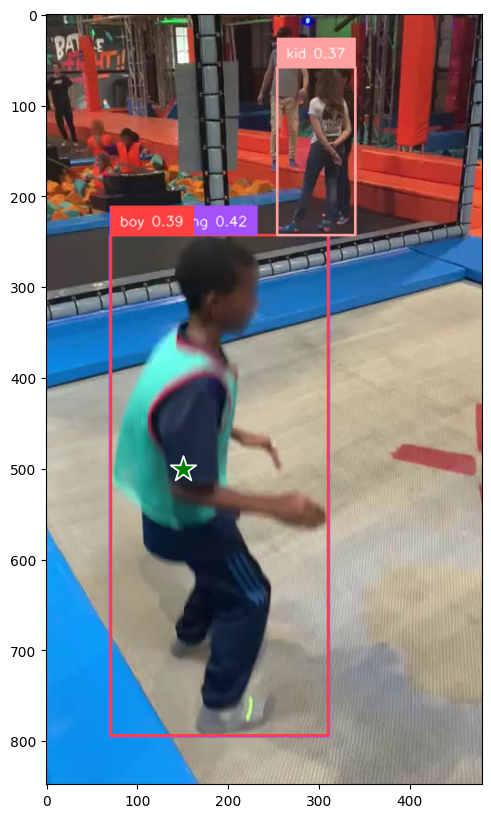

In [7]:
tracker_start = np.array([[150, 500]])

input_file = f"{path}/input_seq/{SEQUENCE_NAME}_IN{sequence_start:04d}.jpg"
image = cv2.imread(input_file)
fheight, fwidth = image.shape[:2]

image_source, image = load_image(input_file)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(annotated_frame)
show_points(tracker_start, np.array([1]), plt.gca())
plt.show()  

### Load Ground Truth for Metrics

In [8]:
if CALCULATE_METRICS:
    sav_dataset = SAVDataset(sav_dir="./sav_train/sav_000")
    frames, manual_annot, auto_annot = sav_dataset.get_frames_and_annotations(SEQUENCE_NAME)

There are 483 frames decoded from ./sav_train/sav_000\sav_000001.mp4 (24fps).
Videos are annotated every 4 frames. To align with the annotations, downsample the video to 121 frames.


### Predict Masks / Save Outputs

  0%|          | 0/483 [00:00<?, ?it/s]

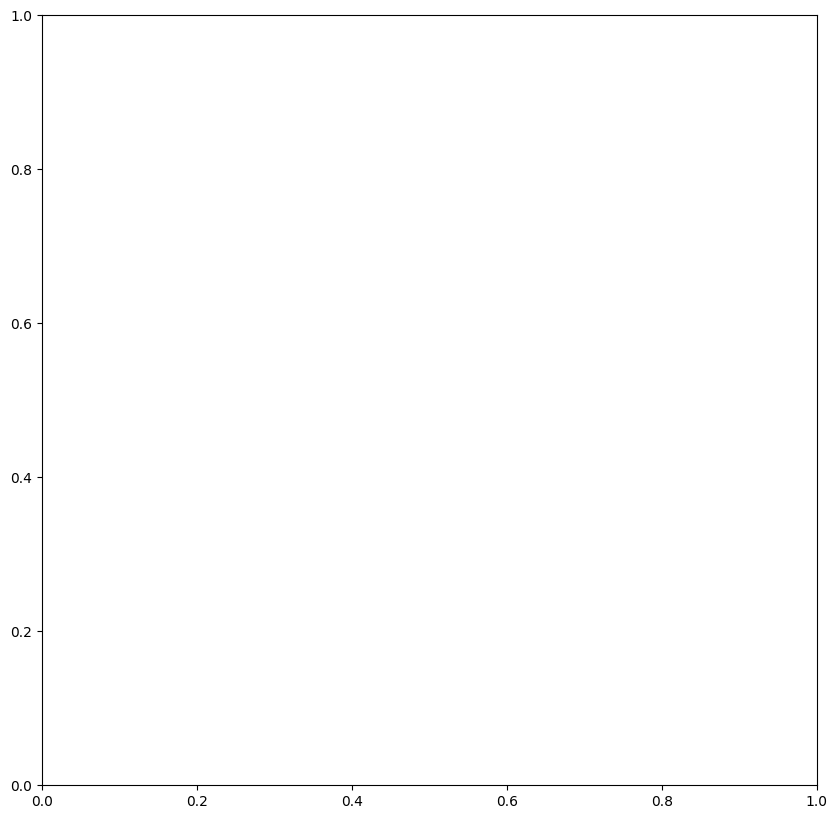

In [19]:
from scipy.ndimage import center_of_mass
import random

center_history = np.vstack([tracker_start] * 5)
# print(center_history.shape)
fig, ax = plt.subplots(figsize=(10, 10))
ious = []

for i in tqdm(range(sequence_start, sequence_end + 1)):

    input_file = f"{path}/input_seq/{SEQUENCE_NAME}_IN{i:04d}.jpg"
    # output_file = f"{path}/output_seq/{SEQUENCE_NAME}_OUT{i:04d}.jpg"

    image_source, image = load_image(input_file)
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    image = cv2.imread(input_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    box_input = boxes.numpy()
    if box_input.shape[0] == 0:
        # ax.imshow(image)
        # show_points(np.array(target_point), np.array([0]), ax)
        # ax.set_title(f"Center at", fontsize=18)
        # ax.axis('off')
        # fig.savefig(output_file)

        # target_point = predict_next_point(center_history)
        # center_history = np.vstack([center_history, target_point])
        continue

    box_input *= np.array([fwidth, fheight, fwidth, fheight])
    centers = box_input[:, 0:2]

    # target_point = predict_next_point(center_history)
    # distances = np.linalg.norm(centers - target_point, axis=1)
    # best_idx = np.argmin(distances)
    best_idx = random.randint(0, len(box_input) - 1)
    best_box = box_input[best_idx, :]  # Choose the mask closest to the predicted point
    # center = centers[best_idx, :]
    # center_history = np.vstack([center_history, center])
    # center_history = center_history[1:, :]

    best_box[0:2] -= best_box[2:4] / 2
    best_box[2:4] += best_box[0:2]

    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=best_box,
        multimask_output=False,
    )

    best_mask = masks[np.argmax(scores), :, :]  # Choose the model's best mask
    
    # # ax.clear()
    # # ax.imshow(image)
    # # show_mask(best_mask, ax)
    # # show_points(np.array(target_point), np.array([1]), ax)
    # # show_box(best_box, ax)
    # # ax.set_title(f"Center at ({float(center[0])}, {float(center[1])})", fontsize=18)
    # # ax.axis('off')
    # # fig.savefig(output_file)
    center = center_of_mass(best_mask)
    prev_point = np.array([[float(center[0]), float(center[1])]])

    # calculate metrics
    if CALCULATE_METRICS and (i - 1) % 4 == 0: # masks only applied every 4 frames
        annotated_frame = (i - 1) // 4
        rles = manual_annot["masklet"][annotated_frame][1:2] 
        masks = [mask_util.decode(rle) > 0 for rle in rles]
        combined_mask = np.any(np.stack(masks), axis=0)
        intersection = np.logical_and(best_mask, combined_mask).sum()
        union = np.logical_or(best_mask, combined_mask).sum()
        iou = intersection / union if union > 0 else 0.0
        ious.append(iou)

In [25]:
# IoU_baseline_all - predict True for the entire frame
# IoU_baseline_mask_center - predict previous center (no momentum)
# IoU_baseline_mask_center_momentum - predict previous center (with momentum)
# IoU_baseline_random_bounding_box - predict random bounding box
# IoU_final
with open('IoU_baseline_random_bounding_box.txt', 'w') as f:
    for item in ious:
        f.write(f"{item}\n")

### Metrics

In [26]:
with open('IoU_baseline_random_bounding_box.txt', 'r') as f:
    ious = [float(line.strip()) for line in f]

Average IoU: 0.6924776070154798


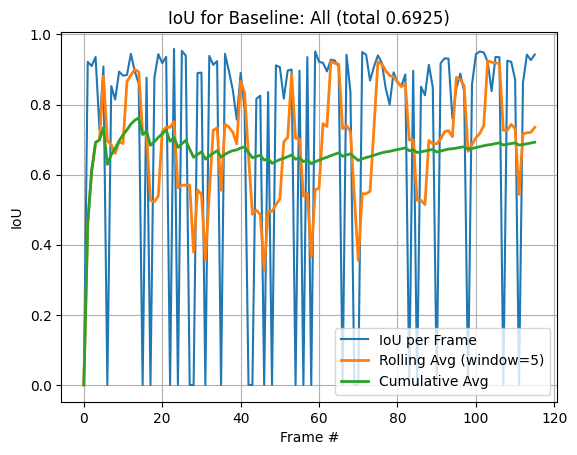

In [27]:
print(f"Average IoU: {np.mean(ious)}")

from collections import deque

rolling_window = deque(maxlen=5)  # Automatically drops oldest entry
rolling_averages = []
cumulative_iou = []

for idx, iou in enumerate(ious):
    rolling_window.append(iou)
    
    avg = sum(rolling_window) / len(rolling_window)
    rolling_averages.append(avg)
    cumulative_iou.append(np.mean(ious[0:idx+1]))

plt.plot(ious, label='IoU per Frame')
plt.plot(rolling_averages, label='Rolling Avg (window=5)', linewidth=2)
plt.plot(cumulative_iou, label='Cumulative Avg', linewidth=2)
plt.title(f"IoU for Baseline: All (total {np.mean(ious):.4f})")
plt.xlabel("Frame #")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.show()

### Final Output

In [ ]:
input_file = f"{path}/output_seq/{SEQUENCE_NAME}_OUT%04d.jpg"
output_file = f"{path}/{SEQUENCE_NAME}_out.mp4"
os.system(f"ffmpeg -framerate 30 -i {input_file} -c:v libx264 -pix_fmt yuv420p {output_file}")